In [2]:
import numpy as np
import pandas as pd
import random
import copy

from math import sqrt, log
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

#### Download datasets

In [3]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

In [4]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

# Visualisation

In [5]:
def get_divisors(number):
  result = {1, number}
  for divisor in range(2, number // 2  + 1):
    if number % divisor == 0:
        result.add(divisor)

  result = list(sorted(result))
  lenght_list = len(result)//2

  return result[lenght_list-1:lenght_list+1]

In [6]:
def separation_to_squares(df: pd.DataFrame, n_squares: int=4) -> dict:

    '''
        if n_squares is not power of 2, separetion will be separate for bigger different of metrics
    '''
    if n_squares < 0:
        print('Separation number is negative')
        return {}
    
    north = df.longitude.max()
    south = df.longitude.min()
    east = df.latitude.max()
    west = df.latitude.min()

    result = dict()

    '''
        search divisors for separetion of square
    '''
    if n_squares ** .5 == int(n_squares ** .5):
        multiplies = [int(sqrt(n_squares))-1]*2
    else:
        multiplies = get_divisors(n_squares)
        if multiplies[0] == 1:
            print('Primal number!')
            return result

    '''
        determine the position vaertical or horizontal
    '''
    if (north - south) > (east - west):
        position = 'vertical'
    else:
        position = 'horizontal'


    minimal = multiplies[0]+1
    maximal = multiplies[1]+1
    if multiplies[0] != multiplies[1]:
        if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal))
                result['latitude'] = list(np.linspace(east, west, maximal))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal))
                result['latitude'] = list(np.linspace(north, south, minimal))
    else:
        if position == 'vertical':
            result['longitude'] = list(np.linspace(north, south, minimal+1))
            result['latitude'] = list(np.linspace(east, west, maximal+1))
        else:
            result['longitude'] = list(np.linspace(east, west, maximal+1))
            result['latitude'] = list(np.linspace(north, south, minimal+1))

    result['longitude'] = result['longitude'][1:-1]
    result['latitude'] = result['latitude'][1:-1]
    result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

    return result


In [7]:
def visualisation_of_squares(df: pd.DataFrame, n_squares: int=4) -> dict:
    if n_squares < 0:
        print('Separation number is negative')
        return dict()
    multiplies = get_divisors(n_squares)
    if multiplies[0] == 1 and not (n_squares ** .5 == int(n_squares ** .5)):
        print('Primal number!')
        return dict()
    
    result = separation_to_squares(df, n_squares)

    fig, axes = plt.subplots(figsize=(12, 12))
    axes.scatter(data=df, x='latitude', y='longitude')

    for x in result['latitude']:
        axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

    for x in result['longitude']:
        axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
        
    axes.set_xlabel('latitude')
    axes.set_ylabel('longitude')

    return result

In [8]:
#visualisation_of_squares(lenght, 9)

#### Math model

In [9]:
model = copy.deepcopy(income)
RUB = 10**6
days = 14
month_day = 30
downtime = 10

In [10]:
tmp = list(income.columns)
model['sum'] = model[tmp].sum(axis=1)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>=14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1


model['test'] = model['number_trips'].round()

In [11]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.loop > 5, 'b', 'a')

In [103]:
pivotmodel2

,limit,quantity,loop,case_loop,category
0,1.0,1,0.071429,14.000000,a
1,2.0,1,0.071429,7.000000,a
2,3.0,2,0.142857,4.666667,a
3,4.0,3,0.214286,3.500000,a
4,5.0,12,0.857143,2.800000,a
5,6.0,20,1.428571,2.333333,a
6,7.0,29,2.071429,2.000000,a
7,8.0,41,2.928571,1.750000,a
8,9.0,38,2.714286,1.555556,a
9,10.0,46,3.285714,1.400000,a


In [12]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

In [105]:
model

,sum,mean,std,day,day_with_limit,number_trips,limit,quantity,test,category
TID,,,,,,,,,,
660401,6226000,67673.913043,627294.839430,14.776743,14.000000,2.142857,14.0,1,2.0,b
682297,12378000,134543.478261,302806.194612,7.432542,7.432542,4.036304,7.0,1,4.0,a
689150,7838000,85195.652174,238542.655855,11.737688,11.737688,2.555870,12.0,1,3.0,a
634558,44171000,480119.565217,128136.675176,2.082815,2.082815,14.403587,2.0,1,14.0,a
688325,8698000,94543.478261,116036.126720,10.577144,10.577144,2.836304,11.0,1,3.0,a
...,...,...,...,...,...,...,...,...,...,...
653954,6160000,66956.521739,18215.989259,14.935065,14.000000,2.142857,14.0,1,2.0,b
657385,3814000,41456.521739,33123.615640,24.121657,14.000000,2.142857,14.0,1,2.0,b
682243,5807000,63119.565217,11180.676414,15.842948,14.000000,2.142857,14.0,1,2.0,b


#### K-Means Classtering

In [13]:
A_category = lenght.merge(model.query('category == "a"')[['test']], left_index=True, right_index=True, how='inner')
B_category = lenght.merge(model.query('category == "b"')[['test']], left_index=True, right_index=True, how='inner')
df = lenght.merge(model[['mean']], left_index=True, right_index=True, how='inner')

In [104]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k):
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]
        # for x in sse:
        #     if x <= self.claster_limit:
        #         c.append(sse.index(x)+1)
        #         c.append(x)
        #         return c

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df, k):
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [15]:
A_category = Clastering(A_category, 'test', 14)
B_category = Clastering(B_category, 'test', 14)
df = Clastering(df, 'number_trips', 14)

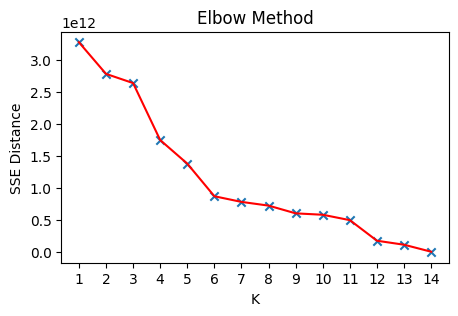

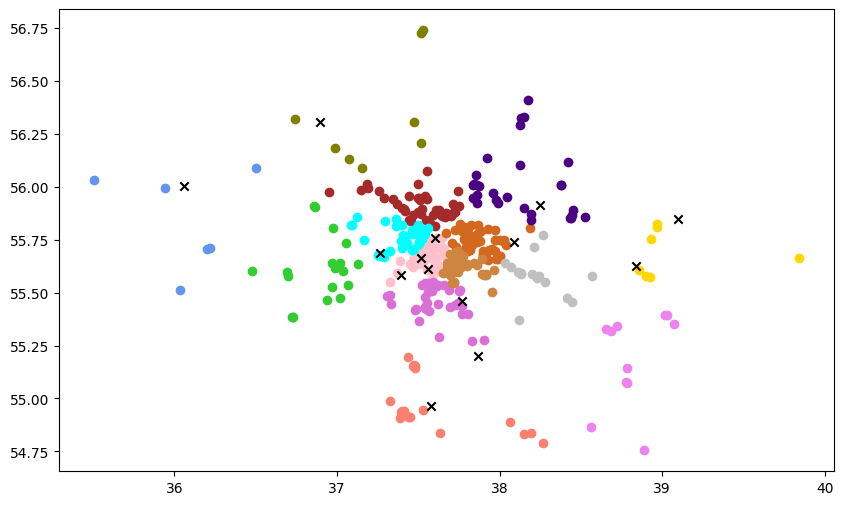

In [16]:
A_category, scce = A_category.selections()
#Clastering.plot_clasters(A_category, scce['clester_count'])

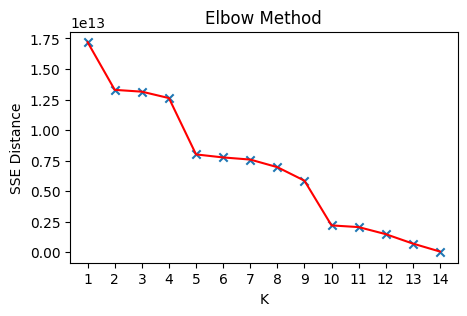

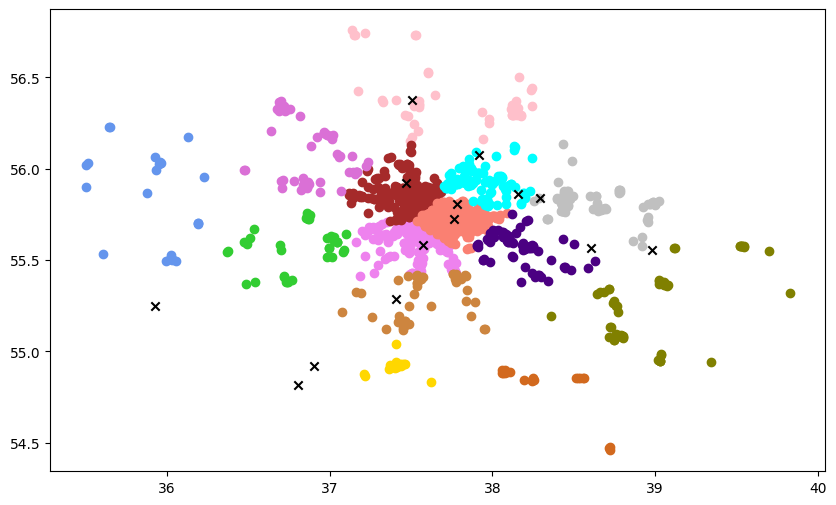

In [17]:
B_category, scce = B_category.selections()
#Clastering.plot_clasters(B_category, scce['clester_count'])

#### K-Means Classtering (added)

In [18]:
A_category = A_category.reset_index()
B_category = B_category.reset_index()
model_added = copy.deepcopy(model)


def float_to_int(base: int, x: float) -> int:
    x = str(x).split('.')
    return int(x[0])*base + int(x[1])

In [19]:
A_claster = times.merge(A_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
A_claster = A_claster.merge(A_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

B_claster = times.merge(B_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
B_claster = B_claster.merge(B_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [20]:
A_claster = A_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})
B_claster = B_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})


In [21]:

l = pd.DataFrame({
      'Mean Time': A_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * A_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))
print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time A'] = l['Mean Time'] * l['Number of points']
l['Total time A / 720'] = l['Total time A'] / 720
print(l['Total time A'].mean())
print(l['Total time A / 720'].mean())
print()
print(l)

35.530521995789464
377
26.928571428571427
739.4440624637115
1.0270056423107101

    Mean Time  Number of points    Time %  Number of cluster  Total time A  \
0   42.159762                 7  0.181054                  0    295.118333   
1   56.925667                 6  0.209542                  1    341.554000   
2   39.673301                18  0.438110                  2    714.119412   
3   51.693364                11  0.348851                  3    568.627000   
4   15.384608                51  0.481359                  4    784.615000   
5   23.145386                46  0.653183                  5   1064.687778   
6   39.421199                19  0.459511                  6    749.002778   
7   19.464925                37  0.441842                  7    720.202222   
8   63.111250                 8  0.309748                  8    504.890000   
9   19.342786                58  0.688271                  9   1121.881579   
10  47.557094                29  0.846108                 10  

In [22]:
l = pd.DataFrame({
      'Mean Time': B_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * B_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))

print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time B'] = l['Mean Time'] * l['Number of points']
l['Total time B / 720'] = l['Total time B'] / 720
print(l['Total time B'].mean())
print(l['Total time B / 720'].mean())
print()
print(l)

34.27640462758098
1253
89.5
2640.6400564715873
3.667555633988315

    Mean Time  Number of points    Time %  Number of cluster  Total time B  \
0   13.767096                17  0.143583                  0    234.040625   
1   55.265108                26  0.881529                  1   1436.892800   
2   37.655412                39  0.900958                  2   1468.561053   
3   25.097878               154  2.371211                  3   3865.073203   
4   45.388960                57  1.587221                  4   2587.170714   
5   24.385409               233  3.485767                  5   5681.800259   
6   19.915397               256  3.127817                  6   5098.341608   
7   27.486205               131  2.209014                  7   3600.692846   
8   55.640798                59  2.013992                  8   3282.807069   
9   35.813360                23  0.505342                  9    823.707273   
10  32.791002                75  1.508788                 10   2459.325135  

In [23]:
A_model = model_added.merge(A_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')
B_model = model_added.merge(B_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')

In [24]:
A_model['downtime'] = downtime * 60
A_model['Total_Time'] = A_model['Total_Time'].apply(lambda x: float_to_int(100, x))
A_model['Common_Time'] = A_model[['Total_Time', 'downtime']].sum(axis=1)
A_model['Car_per_minute'] = 20000/(12*60)
A_model['Maintenance_cost_one_time'] = A_model['Common_Time']/60 * A_model['Car_per_minute']
A_model['Maintenance_cost_per_month'] = A_model['number_trips'] * A_model['Maintenance_cost_one_time']
A_model['Car_time'] = A_model['number_trips'] * A_model['Common_Time']/60
((A_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

1608695.0374396136

In [25]:
B_model['downtime'] = downtime * 60
B_model['Total_Time'] = B_model['Total_Time'].apply(lambda x: float_to_int(100, x))
B_model['Common_Time'] = B_model[['Total_Time', 'downtime']].sum(axis=1)
B_model['Car_per_minute'] = 20000/(12*60)
B_model['Maintenance_cost_one_time'] = B_model['Common_Time']/60 * B_model['Car_per_minute']
B_model['Maintenance_cost_per_month'] = B_model['number_trips'] * B_model['Maintenance_cost_one_time']
B_model['Car_time'] = B_model['number_trips'] * B_model['Common_Time']/60
((B_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

3188793.1721877153

In [26]:
B_claster.drop_duplicates(subset='Origin_tid', keep='first')

,Origin_tid,Destination_tid,Total_Time,cluster
418,680315,682770,16.73,5.0
499,606139,634763,14.37,5.0
793,609468,622362,63.81,7.0
872,629520,622362,64.48,7.0
946,698682,622362,61.32,7.0
...,...,...,...,...
843687,607071,606553,24.94,9.0
860214,606578,662968,29.51,8.0
1000917,690294,606553,25.84,9.0
1189023,635569,619206,101.85,8.0


### Reesrt of routes

In [109]:
income.columns = pd.to_datetime(income.columns).date
B_income = B_claster.drop_duplicates(subset='Origin_tid', keep='first').rename(columns={'Origin_tid': 'TID'}).set_index('TID')[['cluster']].merge(income, left_index=True, right_index=True, how='left')
#A_income = A_claster.drop_duplicates(subset='Origin_tid', keep='first').rename(columns={'Origin_tid': 'TID'}).set_index('TID')[['cluster']].merge(income, left_index=True, right_index=True, how='left')
A_income = model.query('category == "a"')[['limit']].rename(columns={'limit': 'cluster'}).merge(income, left_index=True, right_index=True, how='left')


start = B_income.columns[1]

In [110]:
B_residue = B_income[[start, 'cluster']].reset_index()
B_residue['Date'] = start
B_residue['cluster'] += 1
B_residue['Number_day'] = 0
B_residue = B_residue.rename(columns={'TID': 'Id', start: 'Balance_close'})
B_reestr = pd.DataFrame([], columns=['Id', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day'])
B_reestr = pd.concat([B_reestr, B_residue]).fillna(0)

In [111]:
A_residue = A_income[[start, 'cluster']].reset_index()
A_residue['Date'] = start
A_residue['cluster'] += 1
A_residue['Number_day'] = 0
A_residue = A_residue.rename(columns={'TID': 'Id', start: 'Balance_close'})
A_reestr = pd.DataFrame([], columns=['Id', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day'])
A_reestr = pd.concat([A_reestr, A_residue]).fillna(0)

In [112]:
if True:
    counter = B_income.shape[0]//(14/2)
    for x in list(B_income.columns)[2:]:
        lastday_tmp = x-dt.timedelta(days=1)

        # B category
        B_income_tmp = B_income[[x]].reset_index().rename(columns={'TID': 'Id', x: 'Income'})

        
        B_nextday_tmp = B_reestr.query(f'Date == @lastday_tmp')
        B_nextday_tmp['Date'] += dt.timedelta(days=1)
        B_nextday_tmp = B_nextday_tmp.drop(columns='Income').merge(B_income_tmp, on='Id', how='inner')

        B_nextday_tmp['Balance_open'] = B_nextday_tmp['Balance_close']
        B_nextday_tmp['Balance_close'] = 0

        B_nextday_tmp['Number_day'] += 1
        B_nextday_tmp['Number_day_form_last_serves'] += 1


        B_nextday_tmp['Outcome'] = np.where((B_nextday_tmp.Balance_open >= 10**6) | 
                                            (B_nextday_tmp.Number_day == B_nextday_tmp.cluster) | 
                                            (B_nextday_tmp.Number_day_form_last_serves > 14), 
                                            B_nextday_tmp.Balance_open, 0)
        
        B_nextday_tmp['Number_day'] = np.where((B_nextday_tmp.Number_day > 14), 1, B_nextday_tmp.Number_day)
        B_nextday_tmp['Number_day_form_last_serves'] = np.where((B_nextday_tmp.Outcome != 0), 1, B_nextday_tmp.Number_day_form_last_serves)
        
        B_nextday_tmp['Balance_close'] = B_nextday_tmp.Balance_open + B_nextday_tmp.Income - B_nextday_tmp.Outcome

        B_reestr = pd.concat([B_reestr, B_nextday_tmp]).fillna(0).reset_index(drop=True)


        # A category
        A_income_tmp = A_income[[x]].reset_index().rename(columns={'TID': 'Id', x: 'Income'})

        
        A_nextday_tmp = A_reestr.query(f'Date == @lastday_tmp')
        A_nextday_tmp['Date'] += dt.timedelta(days=1)
        A_nextday_tmp = A_nextday_tmp.drop(columns='Income').merge(A_income_tmp, on='Id', how='inner')

        A_nextday_tmp['Balance_open'] = A_nextday_tmp['Balance_close']
        A_nextday_tmp['Balance_close'] = 0

        A_nextday_tmp['Number_day'] += 1
        A_nextday_tmp['Number_day_form_last_serves'] += 1


        A_nextday_tmp['Outcome'] = np.where((A_nextday_tmp.Balance_open >= 10**6) | 
                                            (A_nextday_tmp.Number_day_form_last_serves == A_nextday_tmp.cluster) | 
                                            (A_nextday_tmp.Number_day_form_last_serves > 14), 
                                            A_nextday_tmp.Balance_open, 0)
        
        A_nextday_tmp['Number_day'] = np.where((A_nextday_tmp.Number_day > 14), 1, A_nextday_tmp.Number_day)
        A_nextday_tmp['Number_day_form_last_serves'] = np.where((A_nextday_tmp.Outcome != 0), 1, A_nextday_tmp.Number_day_form_last_serves)
        
        A_nextday_tmp['Balance_close'] = A_nextday_tmp.Balance_open + A_nextday_tmp.Income - A_nextday_tmp.Outcome

        A_reestr = pd.concat([A_reestr, A_nextday_tmp]).fillna(0).reset_index(drop=True)


        # limit = reestr.query('Date == @x and Outcome != 0').shape[0]
        # if limit >= counter:
        #     continue
        # potencial = list(reestr.query('Date == @x and Outcome == 0').sort_values(by='Balance_open', ascending=False).Id)[:int(counter-limit)]

        # reestr.loc[(reestr.Date == x) & (reestr.Id.isin(potencial)), 'Outcome'] = reestr.Balance_open
        # reestr.loc[(reestr.Id.isin(potencial)) & (reestr.Date == x), 'Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome
        # reestr.loc[(reestr.Id.isin(potencial)) & (reestr.Date == x), 'Number_day'] = 1
    reestr = pd.concat([A_reestr, B_reestr])
    reestr.to_excel(rf'./files/reestr_test.xlsx', index=False)
    A_reestr.to_excel(rf'./files/A_reestr_test.xlsx', index=False)

In [113]:
pivot = pd.read_excel(rf'./files/reestr_test.xlsx')
pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
pivot.to_excel(rf'./files/pivot_test.xlsx')
pivot

,signal
Date,
2022-08-31,0.0
2022-09-01,28.0
2022-09-02,33.0
2022-09-03,66.0
2022-09-04,191.0
...,...
2022-11-26,82.0
2022-11-27,207.0
2022-11-28,107.0


# Маршрутизация


In [114]:
def build_routes(df, max_time):
    points = list(df.columns)
    routes = []
    while points:
        current_time = 0
        route = [points.pop(0)]
        while points:
            # вычисление времени до следующей точки
            next_point = min(points, key=lambda point: df.loc[route[-1], point])
            next_time = df.loc[route[-1], next_point] + 10
            
            # если добавление следующей точки приведет к превышению максимального времени, 
            # завершим текущий маршрут и начнем новый
            if current_time + next_time > max_time:
                #print(current_time + next_time)
                break
            
            route.append(next_point)
            points.remove(next_point)
            current_time += next_time

        routes.append(route)

    return routes

def routes_from_arr_points(category, distance_matrix):
    center = (category['longitude'].mean(), category['latitude'].mean())
    category['distance_to_center'] = np.sqrt((category['longitude'] - center[0]) ** 2 + (category['latitude'] - center[1]) ** 2)
    closest_point_index  = category.loc[[category['distance_to_center'].idxmin()]].to_dict('records')
    
    first_point = closest_point_index[0]['TID']

    set_points = list(set(category['TID']))
    set_points.pop(set_points.index(first_point))
    set_points.insert(0, first_point)
    
    
    df_distance = distance_matrix.loc[set_points, set_points]
    routes = build_routes(df_distance, 720)#2600*0.565)
    count = 1
    for route in routes:
        print(len(route))
        df_ = distance_matrix.loc[route, route]
        
        route = pd.DataFrame({'First': route[:-1], 'Second': route[1:]})
        route = route.merge(times, left_on=['First', 'Second'], right_on=['Origin_tid','Destination_tid'])
        route = route.merge(lenght, left_on=['First'], right_on=['TID'])
        route = route.rename(columns = {'longitude':'longitude1', 'latitude':'latitude1'})
        route['Total_Time'] = route['Total_Time'] + 10

        route = route.merge(lenght, left_on=['Second'], right_on=['TID'])
        route = route.rename(columns = {'longitude':'longitude2', 'latitude':'latitude2'})

        route = route.drop(columns = ['Origin_tid', 'Destination_tid'])

        route['Idle'] = 10
        route['Delivery'] = route['Total_Time']-10
        route = route[['First', 'Second', 'longitude1', 'latitude1', 'longitude2', 'latitude2', 'Total_Time', 'Idle', 'Delivery']]
        route.to_excel(rf'./routes/route_number_{count}.xlsx', index=False)
        count += 1

In [131]:
lenght_tmp = lenght.reset_index()
day_tmp = dt.date(2022, 11, 30)
route_tmp = pd.read_excel(rf'./files/reestr_test.xlsx').query('Date == @day_tmp and Outcome !=0')
lenght_tmp = lenght_tmp.loc[lenght_tmp.TID.isin(list(route_tmp.Id))]

In [132]:
len(lenght_tmp)

281

In [133]:
routes_from_arr_points(lenght_tmp, distance_matrix)

56
58
55
50
39
20
3
